# First `politician2vec` demo

In [1]:
%pip uninstall politician2vec -y

Found existing installation: politician2vec 0.0.1
Uninstalling politician2vec-0.0.1:
  Successfully uninstalled politician2vec-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install git+ssh://git@github.com/mathiasbruun/politician2vec.git

  Cloning ssh://****@github.com/mathiasbruun/politician2vec.git to /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-req-build-gex5jaqi
  Running command git clone -q 'ssh://****@github.com/mathiasbruun/politician2vec.git' /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-req-build-gex5jaqi
  Created wheel for politician2vec: filename=politician2vec-0.0.1-py3-none-any.whl size=27416 sha256=a4a9cceeae7cd65b2cb9e047e20e4b65765401a7dca7c0b330a0abe16ea3a3a9
  Stored in directory: /private/var/folders/8q/02vc3fzn3r1fv7wzycyspjz80000gn/T/pip-ephem-wheel-cache-i729_9ok/wheels/ac/44/62/b0b3ddf2882cd1b1d1cc4e060c5c525b951ae01496d65cd472
Successfully built politician2vec
Note: you may need to restart the kernel to use updated packages.


In [3]:
from politician2vec import Politician2Vec
from politician2vec.utils import *
import pickle
import pandas as pd
import numpy as np
import multiprocessing
available_workers = multiprocessing.cpu_count()
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mathiasbruun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
test_data_path = 'data/clean/combined/subset_party_imputed_v2.p'

In [13]:
with open(test_data_path, 'rb') as p:
    test_data = pickle.load(p)

test_data.shape

(349594, 7)

In [14]:
test_data['party'].value_counts()

S      80003
V      58671
EL     37903
SF     33652
RV     28769
DF     26535
KF     22295
LA     18853
ALT    14528
FG     10668
NB      8939
UFG     6743
KD       935
SIU      269
M        222
JF       216
DD       193
SP       157
NQ        43
Name: party, dtype: int64

In [569]:
# parl_data = test_data.loc[
#     (test_data['source'] == 'parliament') #&
#    # ~(test_data['party'].isin(['SIU', 'NQ', 'JF', 'SP']))
# ]
#
tw_data = test_data.loc[
    test_data['source'] == 'twitter'
]

meta_data = test_data.loc[
    (test_data['source'] == 'meta') &
    test_data['doc'].notna()
]

In [16]:
tw_data['party'].value_counts(dropna = False)

S      54566
V      36976
EL     27629
RV     21790
SF     21593
KF     13364
DF     12291
ALT    11278
LA     10844
FG      9336
UFG     5444
NB      1834
KD       239
M        157
DD        16
Name: party, dtype: int64

In [17]:
grouped_docs = tw_data.groupby(['full_name', 'party'])['doc'].apply('. '.join).reset_index()

In [18]:
docs = [doc for doc in grouped_docs.doc]
parties = np.array([party for party in grouped_docs.party])

In [10]:
ngram_options = {
    'min_count': 5,
    'threshold': 1,
    'delimiter': '_'
}

In [11]:
pol2vec_model = Politician2Vec(
    documents = docs,
    custom_clusters = parties,
    party_inference_method = 'mean',
    tokenizer = preproc_docs,
    embedding_model = 'doc2vec',
    min_count = 50,
    ngram_vocab = True,
    ngram_vocab_args = ngram_options,
    speed = 'fast-learn', # CHANGE FOR REAL RUNS
    workers = available_workers
    #doc2vec_vector_size = 300,
    #doc2vec_window = 8,
    #doc2vec_samples_threshold = 1e-5
)

2022-12-09 12:17:17,636 - politician2vec - INFO - Pre-processing documents for training
2022-12-09 12:17:52,547 - politician2vec - INFO - Creating joint document/word embedding
2022-12-09 12:24:29,288 - politician2vec - INFO - Estimating party positions using mean...
2022-12-09 12:24:29,573 - politician2vec - INFO - All done!


In [36]:
# TODO: This should probably be implemented as a method of the Politician2Vec class
#
# NOTE: As of 2022-11-26, it has been decided to keep party 'inference' parallel to the original top2vec implementation.
#       This funtionality may prove useful in outlier detection, but--importantly--it requires the ex ante known party affilaitions
#       to be mapped to model output ex post instead of relying on inferred parties. Specifically, the 'estimated' party affiliations
#       may vary from ground truth labels in the case of semantically outlying politicians with only few data points.

def inspect_party(politician2vec_model, party_idx, n_docs=None, query_substr=None):
    '''
    Print top words and top docs for a given
    party.
    -------
    manual_num (int):  automatically assigned party number (i.e. 0-indexed).
    
    n_docs (int, optional): n top documents to print for a given party.
        Default is to print all docs within a given party.
    
    query_substr (str, optional): if specified, only documents containing
        this substring will be printed. Cannot be specified with n_docs,
        as this would return only results within a subset of party docs.
    '''

    num_parties = politician2vec_model.get_num_parties()
    party_words, word_scores, party_nums = politician2vec_model.get_parties(num_parties)

    # Get party sizes so we know max n docs
    party_sizes, party_nums = politician2vec_model.get_party_sizes()
    docs_to_return = party_sizes[party_idx]

    # Override n docs to return, if specified
    if n_docs:
        docs_to_return = n_docs

    # Get docs for input party id
    documents, document_scores, document_ids = politician2vec_model.search_documents_by_party(
        party_num=party_idx,
        num_docs=docs_to_return
        )

    # Limit output to docs containign certain substring, if specified
    if query_substr and n_docs:
        raise Exception('Please do NOT specify n_docs with substring query!\nOtherwise the search is only carried out for a subset of party docs.')
    
    # Throw exception if substring query attempted on subset of docs!
    elif query_substr:
        documents = [doc for doc in documents if query_substr in doc.lower()]

    # Print output
    print('--- TOP 50 WORDS ---\n', party_words[party_idx], '\n')

    print(f'--- TOP {docs_to_return} DOCS. SUBSTRING QUERY: {query_substr} (n = {len(documents)}) ---\n', documents)

In [13]:
word_vectors = pol2vec_model.model.wv
word_vectors.most_similar(positive = ['borgerlige'], topn = 25)

[('partier', 0.48876437544822693),
 ('siger', 0.4446183145046234),
 ('hvorfor', 0.42696040868759155),
 ('borgerlig', 0.4245670735836029),
 ('venstre', 0.42446768283843994),
 ('politik', 0.42077675461769104),
 ('blå', 0.4204168915748596),
 ('socialdemokratiet', 0.41995492577552795),
 ('nye', 0.41983532905578613),
 ('ønsker', 0.4193897545337677),
 ('se', 0.41327038407325745),
 ('mere', 0.41259878873825073),
 ('tilbage', 0.4113962948322296),
 ('k', 0.4100954234600067),
 ('blok', 0.4094802141189575),
 ('dkpol', 0.40509071946144104),
 ('får', 0.39996597170829773),
 ('sidste', 0.39719483256340027),
 ('v', 0.39556077122688293),
 ('borgerliges', 0.394281804561615),
 ('folketinget', 0.39394763112068176),
 ('igen', 0.3935641348361969),
 ('lade', 0.3932124078273773),
 ('kun', 0.39048442244529724),
 ('mener', 0.3870459496974945)]

In [177]:
inspect_party(pol2vec_model, 1, n_docs=1, query_substr=None)

--- TOP 50 WORDS ---
 ['jesperpet' 'spolitik' 'phummelgaard' 'rabjergmadsen' 'rstoklund' '🌹'
 'bennyengelbrech' 'astridkrag' 'rosenkrantzt' 'jensjoel' 'heunicke'
 'mattiastesfaye' 'mfmorten' 'danjoergensen' 'mjohnsondk' 'anehalsboe'
 'sandkjaer' 'frlass' 'phummelgaard vigtig' 'bjbrandenborg'
 'rt bennyengelbrech' 'bennyengelbrech dag' 'rt phummelgaard'
 'phummelgaard godt' 'phummelgaard uhyre' 'regeringdk'
 'bennyengelbrech tak' 'mogensjensens' 'rt mogensjensens' 'rt jesperpet'
 'rt anehalsboe' 'netavisenpio' 'simonkollerup' 'jeppebruus'
 'phummelgaard fremragende' 'anehalsboe tak' 'rt mfmorten' 'uvmdk'
 'rt statsmin' 'mogensjensens godt' 'jesperpet godt' 'statsmin renere'
 'jeppekofod' 'jesperpet siger' 'jeres' 'rasmushorn'
 'nwammen forfærdelige' 'stærkt' 'phummelgaard tillykke'
 'mfmorten eu-forsvarsministre'] 

--- TOP 1 DOCS. SUBSTRING QUERY: None (n = 1) ---
 ['RT @BennyEngelbrech: Papes plan om at afskaffe topskatten - det dyreste af K\'s skatteforslag - er markant dyrere, end h

In [4]:
model_path = 'embedding_models/politician2vec_test_deeplearn_v3.txt'
#model_path = 'embedding_models/politician2vec_meta_deeplearn_v1.txt'
#model_path = 'embedding_models/politician2vec_parl_deeplearn_v1.txt'
#model_path = 'embedding_models/politician2vec_tw_fastlearn_preproc.txt'

In [16]:
#pol2vec_model.save(model_path)

_____

## Viz dev

In [5]:
pol2vec_model, doc2vec_model = load_politician2vec_from_txt(model_path)

Loading Politician2Vec model...
Retrieving document embedding...
All done!


In [18]:
n_words = len(doc2vec_model.wv)
n_docs = len(doc2vec_model.dv)
vocab = pol2vec_model.vocab

In [ ]:
# # TWITTER DEEPLEARN
# party_labels = {
#    0: 'Venstre',
#    1: 'Socialdemokratiet',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale_Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'Alternativet',
#    9: 'Nye_Borgerlige',
#    10: 'Frie_Grønne',
#    11: 'Kristendemokraterne',
#    12: 'Moderaterne'
# }

In [ ]:
## PARLIAMENT FASTLEARN
#party_labels = {
#    0: 'Socialdemokratiet',
#    1: 'Venstre',
#    2: 'Dansk_Folkeparti',
#    3: 'Enhedslisten',
#    4: 'Radikale Venstre',
#    5: 'SF',
#    6: 'Konservative',
#    7: 'Liberal_Alliance',
#    8: 'UFG',
#    9: 'Alternativet',
#    10: 'Danmarksdemokraterne',
#    11: 'Nye Borgerlige',
#    12: 'Frie Grønne',
#    13: 'Moderaterne',
#    14: 'Kristendemokraterne'
#}

In [7]:
# META FASTLEARN
party_labels = {
   0: 'Socialdemokratiet',
   1: 'Venstre',
   2: 'Dansk_Folkeparti',
   3: 'SF',
   4: 'Enhedslisten',
   5: 'Radikale_Venstre',
   6: 'Konservative',
   7: 'Liberal_Alliance',
   8: 'Alternativet',
   9: 'Danmarksdemokraterne',
   10: 'Nye_Borgerlige',
   11: 'UFG',
   12: 'Frie_Grønne',
   13: 'Kristendemokraterne',
   14: 'Grønlandsk',
   15: 'Moderaterne'
}

In [19]:
party_df = get_doc_party_df(
    pol2vec_model,
    no_substantive_parties = 19,
    snippets = True
)

Topic sizes before filtering (topic 19 is "Other"):

[[ 0 35]
 [ 1 32]
 [ 2 15]
 [ 3 15]
 [ 4 13]
 [ 5 12]
 [ 6 11]
 [ 7  7]
 [ 8  6]
 [ 9  6]
 [10  5]
 [11  3]
 [12  3]
 [13  2]
 [14  1]]


In [20]:
import umap
import umap.plot
from bokeh.models import Label, LabelSet, ColumnDataSource
umap.plot.output_notebook(hide_banner=True)
from adjustText import adjust_text

In [21]:
colormap = {
    'S': '#C8042C',
    'V': '#1A4289',
    'DF': '#265BA4',
    'EL': '#BF2850',
    'SF': '#B42D27',
    'KF': '#24573E',
    'RV': '#D82E8A',
    'LA': '#E7B657',
    'ALT': '#75FB4C',
    'NB': '#1E4B57',
    'KD': '#566197',
    'FG': '#E4F04E',
    'DD': '#3470BC',
    'M': '#7A308B',
    'SIU': 'lightgrey',
    'UFG': 'lightgrey'
}

In [22]:
party_df['party'] = parties
party_df['color'] = party_df['party'].map(colormap)
cmap = party_df[['snippet', 'color']].set_index('snippet').to_dict()
party_df['full_name'] = grouped_docs['full_name']

In [23]:
party_labels = party_df.drop_duplicates(keep = 'last', subset = 'party')[['party', 'party']].sort_values(by = 'party').set_index('party').reset_index(drop=True)

In [24]:
party_labels

,party
0,V
1,S
2,DF
3,EL
4,RV
5,KF
6,SF
7,UFG
8,LA
9,ALT


In [25]:
partyvecs = pol2vec_model.party_vectors
partylabels = pd.DataFrame(party_labels['party'])

In [26]:
combined_hover = pd.concat([party_df, partylabels]).reset_index(drop=True)
combined_hover['color'] = combined_hover['color'].fillna('black')

In [10]:
mapper = umap.UMAP(
    n_neighbors=15,
    metric='cosine',
    n_components=3
    ).fit(
        np.vstack([
            pol2vec_model.document_vectors,
            pol2vec_model.party_vectors
            ])
    ) # label supervision: y = combined_hover['party'].astype('category').cat.codes

In [528]:
pol2vec_model.model.wv.most_similar(positive = ['kompromis'], topn = 35)

[('nationalt', 0.5400652885437012),
 ('nationale', 0.4259306788444519),
 ('forsvar', 0.40996015071868896),
 ('historisk', 0.4052625298500061),
 ('sikkerhedspolitik', 0.3619118332862854),
 ('fælles', 0.33600059151649475),
 ('ja', 0.33374789357185364),
 ('naturgas', 0.32885000109672546),
 ('forsvarsforbeholdet', 0.3193390965461731),
 ('samarbejde', 0.3054887652397156),
 ('europa', 0.3034357726573944),
 ('bruge', 0.3011946380138397),
 ('europæiske', 0.2980431616306305),
 ('forsvarsforbehold', 0.29767268896102905),
 ('enige', 0.2948877513408661),
 ('nej', 0.29466700553894043),
 ('sammen', 0.29060274362564087),
 ('afskaffe', 0.2869146764278412),
 ('virkelighed', 0.28624287247657776),
 ('vores', 0.2827325761318207),
 ('politik', 0.28118982911109924),
 ('forbehold', 0.28080251812934875),
 ('kræfter', 0.28011834621429443),
 ('imod', 0.27817729115486145),
 ('frihed', 0.2765197455883026),
 ('forsvaret', 0.27457109093666077),
 ('eu', 0.2718961238861084),
 ('stedet', 0.2711709439754486),
 ('giver'

In [183]:
def find_party_words_and_scores(pol2vec_model):
    party_words = []
    party_word_scores = []

    res = np.inner(pol2vec_model.party_vectors, pol2vec_model.word_vectors)
    party_words = np.flip(np.argsort(res, axis=1), axis=1)
    party_scores = np.flip(np.sort(res, axis=1), axis=1)

    for words, scores in zip(party_words, party_scores):
        party_words.append([pol2vec_model.vocab[i] for i in words[0:350]])
        party_word_scores.append(scores[0:350])

    party_words = np.array(party_words)
    party_word_scores = np.array(party_word_scores)

    return party_words, party_word_scores

In [407]:
find_party_words_and_scores(pol2vec_model)[0][1]

array(['jesperpet', 'spolitik', 'phummelgaard', 'rabjergmadsen',
       'rstoklund', '🌹', 'bennyengelbrech', 'astridkrag', 'rosenkrantzt',
       'jensjoel', 'heunicke', 'mattiastesfaye', 'mfmorten',
       'danjoergensen', 'mjohnsondk', 'anehalsboe', 'sandkjaer', 'frlass',
       'phummelgaard vigtig', 'bjbrandenborg', 'rt bennyengelbrech',
       'bennyengelbrech dag', 'rt phummelgaard', 'phummelgaard godt',
       'phummelgaard uhyre', 'regeringdk', 'bennyengelbrech tak',
       'mogensjensens', 'rt mogensjensens', 'rt jesperpet',
       'rt anehalsboe', 'netavisenpio', 'simonkollerup', 'jeppebruus',
       'phummelgaard fremragende', 'anehalsboe tak', 'rt mfmorten',
       'uvmdk', 'rt statsmin', 'mogensjensens godt', 'jesperpet godt',
       'statsmin renere', 'jeppekofod', 'jesperpet siger', 'jeres',
       'rasmushorn', 'nwammen forfærdelige', 'stærkt',
       'phummelgaard tillykke', 'mfmorten eu-forsvarsministre', 'gode',
       'spolitik fire', 'rt nwammen', 'rt jeppekofod', 

In [191]:
UMAP_projections = []

for seed in tqdm(range(0,15)):

    politician_mapper = umap.UMAP(
        n_neighbors=15,
        metric='cosine',
        n_components=3,
        random_state=seed
        ).fit(
            np.vstack([
                pol2vec_model.document_vectors,
                pol2vec_model.party_vectors
                ])
        )

    words_reduced = politician_mapper.transform(
        pol2vec_model.word_vectors
            )

    UMAP_projections.append((politician_mapper, words_reduced))

  0%|          | 0/15 [00:00<?, ?it/s]

In [554]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('seaborn-whitegrid')
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['mathtext.fontset'] = 'custom'
# plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

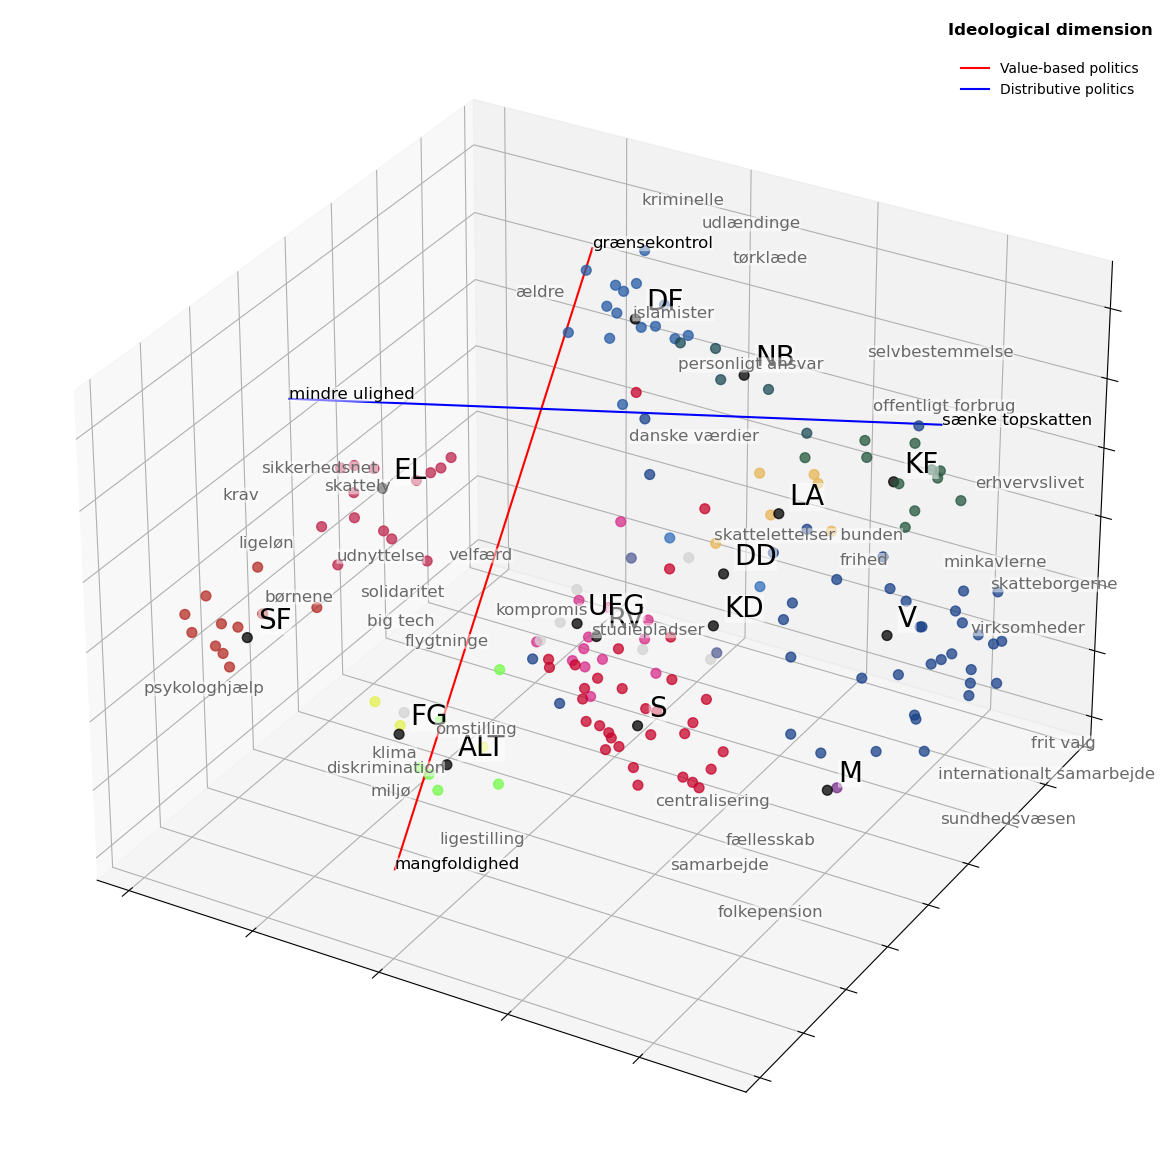

In [555]:
# Learning a 2D mapping of politician/party vectors and projecting words onto this "party space".
# Note that this is purely for visualisation purposes, since both words and documents are already
# embedded in the original 300D space--however, simply reducing the entire space at once runs the
# risk of the model distinguishing too clearly between word vecs and doc vecs and therfore placing
# them too far apart from each other.


for politician_mapper, words_reduced in UMAP_projections[10:11]:

    words_to_draw = [
        'danske værdier',
        'mangfoldighed',
        'frit valg',
        'børnene',
        'selvbestemmelse',
        'diskrimination',
        'islamister',
        'tørklæde',
        'kriminelle',
        'udlændinge',
        'personligt ansvar',
        'folkepension',
        'flygtninge',
        'grænsekontrol',
        'psykologhjælp',
        'offentligt forbrug',
        'skattelettelser bunden',
        'ligestilling',
        'erhvervslivet',
        'skattely',
        'ligeløn',
        'virksomheder',
        'centralisering',
        'fællesskab',
        'minkavlerne',
        'sænke topskatten',
        'klima',
        'miljø',
        'studiepladser',
        'solidaritet',
        'ældre',
        'frihed',
        'internationalt samarbejde',
        'sundhedsvæsen',
        'udnyttelse',
        'sikkerhedsnet',
        'mindre ulighed',
        'kompromis',
        'krav',
        'skatteborgerne',
        'big tech',
        'velfærd',
        'samarbejde',
        'omstilling'
    ]

    class PopulismWords:
        def __init__(self, projected_words, words_to_draw: 'list', antonym_pairs: 'list of tuples'):
            self.projection = projected_words
            self.vocab = words_to_draw
            self.antonyms = antonym_pairs
            self.word_coords = []

            for word in words_to_draw:
                self.word_coords.append(self.get_word_coords(word, self.projection))

        def get_word_coords(self, word, projected_words):
            idx = pol2vec_model.vocab.index(word)
            word_pos = projected_words[idx]

            return word_pos

        def get_antonym_coords(self, idx):
            antonym_coords = []
            pair = self.antonyms[idx]
            
            for word in pair:
                antonym_coords.append(self.get_word_coords(word, self.projection))

                xyz_coords = np.vstack(antonym_coords).T

            return xyz_coords[0], xyz_coords[1], xyz_coords[2]
        
        def write_words(self, ax):

            for word, word_pos in zip(self.vocab, self.word_coords):

                text_args = {
                'x': word_pos[0],
                'y': word_pos[1],
                'z': word_pos[2],
                'size': 12,
                'color': 'black',
                'bbox': dict(
                        facecolor='white',
                        alpha = .5,
                        edgecolor='none',
                        boxstyle='round,pad=0'
                        )
                    }

                if word in populism_words.antonyms[0]+populism_words.antonyms[len(populism_words.antonyms)-1]:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = text_args['color'],
                        bbox=text_args['bbox']
                    )

                else:
                    ax.text(
                        text_args['x'],
                        text_args['y'],
                        text_args['z'],
                        word,
                        size=text_args['size'],
                        c = 'dimgrey',
                        bbox=text_args['bbox']
                    )

        def draw_antonym_line(self, idx, ax, color = 'g', label = 'label here'):
            x, y, z = self.get_antonym_coords(idx)

            ax.plot(
                x,
                y,
                z,
                color = color,
                label = label
            )
            
    populism_words = PopulismWords(
        words_reduced,
        words_to_draw,
        antonym_pairs = [
            ('grænsekontrol', 'mangfoldighed'),
            ('sænke topskatten', 'mindre ulighed')
            ]
        )
    # TWITTER WORD SPACE MAPPING
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    xdata = politician_mapper.embedding_.T[0]
    ydata = politician_mapper.embedding_.T[1]
    zdata = politician_mapper.embedding_.T[2]

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    ax.scatter3D(
        xdata,
        ydata,
        zdata,
        c=combined_hover['color'],
        cmap=combined_hover['color'],
        alpha = 0.75,
        s = 50
        )

    for vec_idx in range(166,181):
        x = politician_mapper.embedding_[vec_idx].T[0]
        y = politician_mapper.embedding_[vec_idx].T[1]
        z = politician_mapper.embedding_[vec_idx].T[2]
        
        ax.text(
            x+0.05,
            y+0.05,
            z+0.05,
            combined_hover.iloc[vec_idx]['party'],
            size=20,
            bbox=dict(
                facecolor='white',
                alpha = .5,
                edgecolor='none',
                boxstyle='round,pad=0'
                )
            )

    populism_words.write_words(ax)
    populism_words.draw_antonym_line(0, ax, color = 'r', label = 'Value-based politics')
    populism_words.draw_antonym_line(1, ax, color = 'b', label = 'Distributive politics')
    # populism_words.draw_antonym_line(2, ax, color = 'b', label = 'inclusive politics/moralised politics')
    plt.legend(
        title = 'Ideological dimension\n',
        frameon = False,
        title_fontproperties={
            'size': 'large',
            'weight':'bold'
            }
        )

    #plt.savefig(f'/Users/mathiasbruun/Downloads/output_classic_seed_{seed}.png')
    
    plt.show()

In [ ]:
   # POPULISM TERMS
    #     'danske værdier',
    #     'internationalt samarbejde',
    #     'folkevalgte',
    #     'løgn',
    #     'sandhed',
    #     'onde',
    #     'forkert',
    #     'enighed',
    #     'dansk',
    #     'fair',
    #     'retfærdig',
    #     'skamme',
    #     'usandt',
    #     'ærlig',
    #     'skuffende',
    #     'danske statsborgere',
    #     'vilje',
    #     'værdi',
    #     'diversitet',
    #     'hårdtarbejdende',
    #     'vælgerne',
    #     'folket',
    #     'ligeglad',
    #     'selvbestemmelse',
    #     'byde velkommen'

### Interactive UMAP plot (2D only)

In [48]:
plab_source = ColumnDataSource(dict(
    x = list(mapper.embedding_.T[0][166:]),
    y=list(mapper.embedding_.T[1][166:]),
    text=list(combined_hover.loc[combined_hover['full_name'].isna(), 'party'].values)
    ))

In [49]:
# TWITTER, PREPROC MENTIONS
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [215]:
# PARLIAMENT
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [161]:
# META
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

In [50]:
# TWITTER
p = umap.plot.interactive(
    mapper,
    labels = combined_hover['party'],
    color_key = combined_hover['color'],
    point_size = 7,
    hover_data = combined_hover.drop(columns=['snippet'])
    )

labels = LabelSet(
    x='x',
    y='y',
    text='text',
    x_offset=5,
    y_offset=5,
    source=plab_source,
    render_mode='canvas',
    
    )

p.add_layout(labels)

umap.plot.show(p)

### PCA: Project parties to first principal component

In [217]:
pca = PCA(n_components=3)

In [218]:
reduced = pca.fit_transform(
    np.vstack([
        #pol2vec_model.document_vectors,
        pol2vec_model.party_vectors
        ]))

In [242]:
only_party_labs

,doc,top,snippet,party,color,full_name
0,NaN,NaN,NaN,S,#C8042C,NaN
1,NaN,NaN,NaN,V,#1A4289,NaN
2,NaN,NaN,NaN,DF,#265BA4,NaN
3,NaN,NaN,NaN,EL,#BF2850,NaN
4,NaN,NaN,NaN,LA,#E7B657,NaN
5,NaN,NaN,NaN,RV,#D82E8A,NaN
6,NaN,NaN,NaN,SF,#B42D27,NaN
7,NaN,NaN,NaN,KF,#24573E,NaN
8,NaN,NaN,NaN,UFG,lightgrey,NaN
9,NaN,NaN,NaN,ALT,#75FB4C,NaN


In [248]:
only_party_labs = combined_hover
only_party_labs.loc[only_party_labs['full_name'].notna(),'party'] = ''
only_party_labs = only_party_labs[241:].reset_index(drop=True)

In [252]:
only_party_labs['color'] = only_party_labs['party'].map(colormap)
#only_party_labs['color'] = only_party_labs['color'].fillna('lightgrey')

In [253]:
only_party_labs

,doc,top,snippet,party,color,full_name
0,NaN,NaN,NaN,S,#C8042C,NaN
1,NaN,NaN,NaN,V,#1A4289,NaN
2,NaN,NaN,NaN,DF,#265BA4,NaN
3,NaN,NaN,NaN,EL,#BF2850,NaN
4,NaN,NaN,NaN,LA,#E7B657,NaN
5,NaN,NaN,NaN,RV,#D82E8A,NaN
6,NaN,NaN,NaN,SF,#B42D27,NaN
7,NaN,NaN,NaN,KF,#24573E,NaN
8,NaN,NaN,NaN,UFG,lightgrey,NaN
9,NaN,NaN,NaN,ALT,#75FB4C,NaN


28

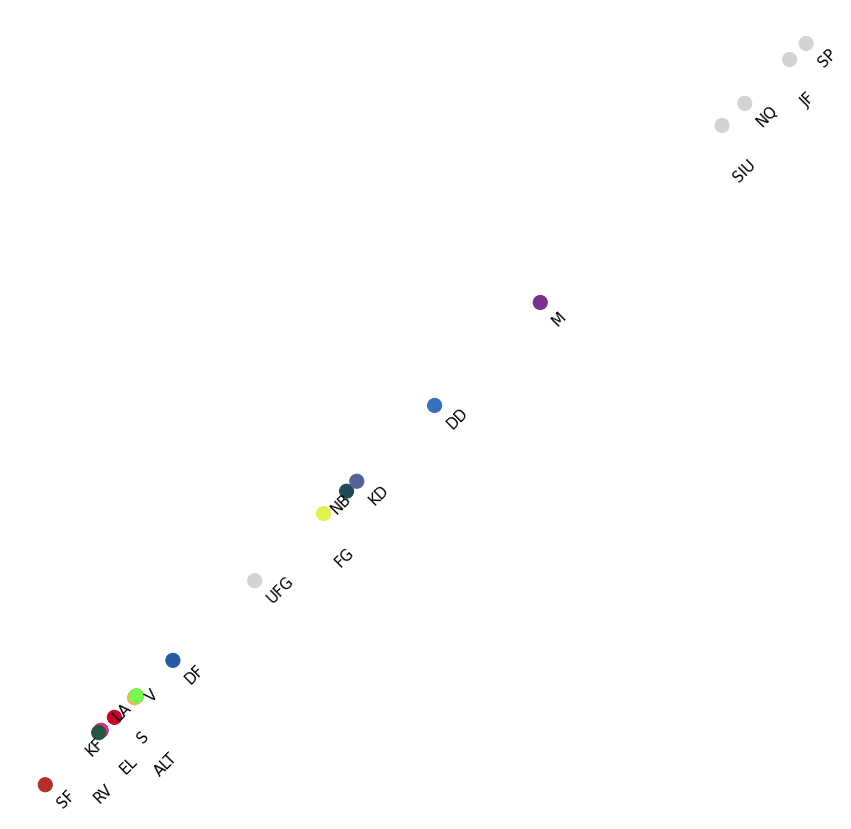

In [296]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

5

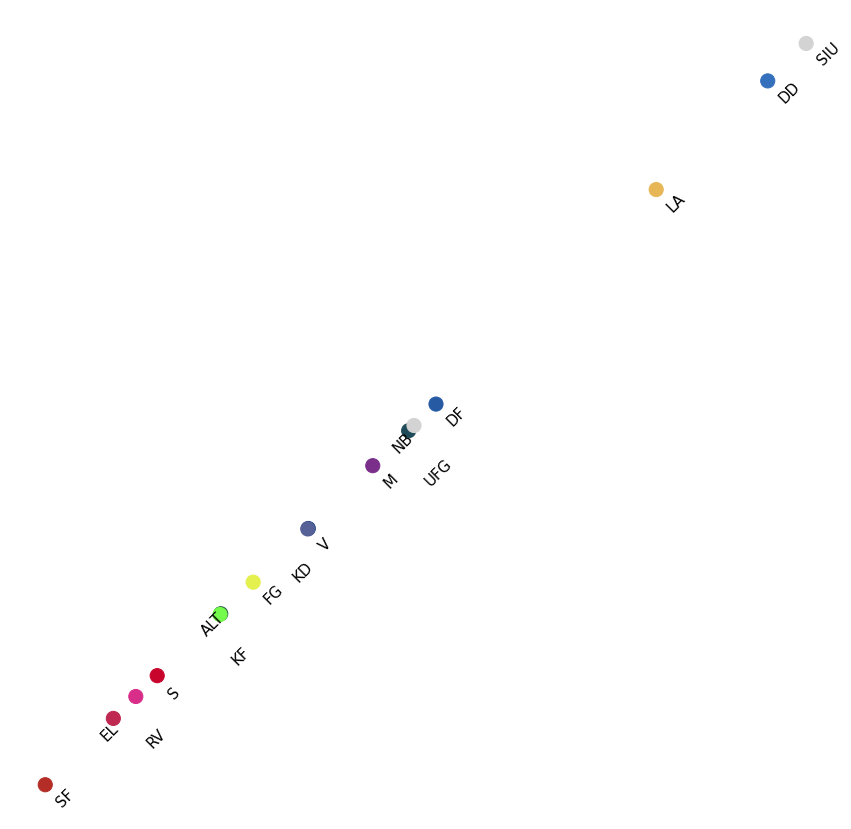

In [168]:
# META
fig = plt.figure(figsize=(15,15))
component = 1

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

labs_list = []

for i in range(len(reduced)):
    lab = plt.text(s = only_party_labs['party'][i], x = reduced.T[component][i]+0.01, y = reduced.T[component][i]-0.035, size = 15, rotation = 45)
    labs_list.append(lab)

adjust_text(labs_list)

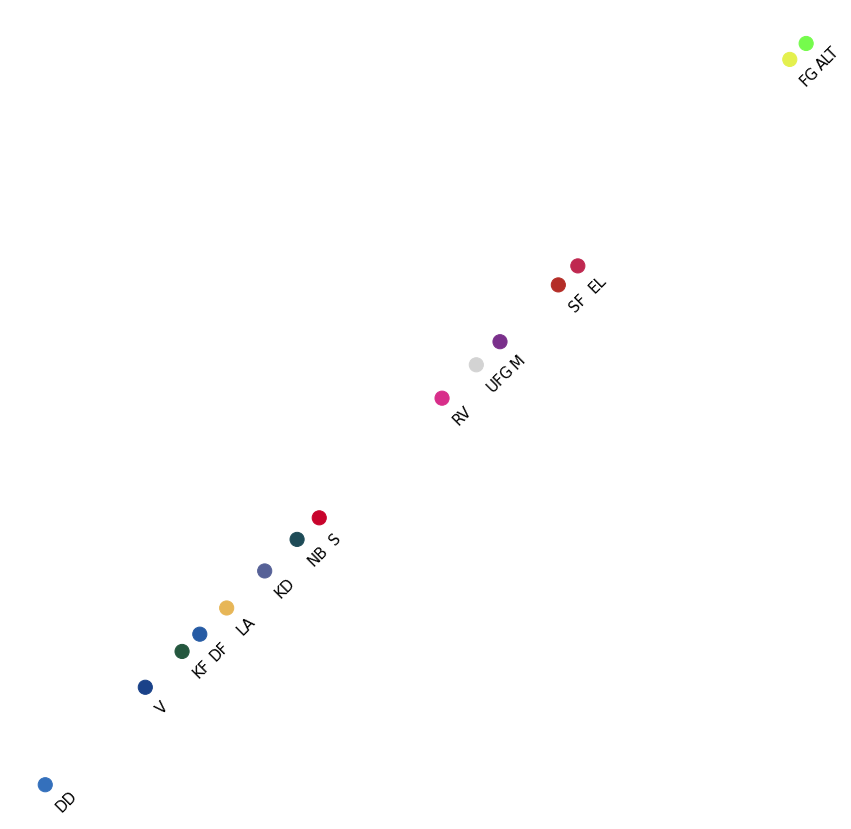

In [545]:
# TWITTER
fig = plt.figure(figsize=(15,15))
component = 0

ax = plt.scatter(
    x = reduced.T[component],
    y = reduced.T[component],
    c=only_party_labs['color'],
    s = 200,
    marker = 'o'
    )

plt.axis('off')

for i in range(len(reduced)):
    plt.annotate(only_party_labs['party'][i], (reduced.T[component][i]+0.01, reduced.T[component][i]-0.035), size = 15, rotation = 45)

### Static 3D UMAP plot

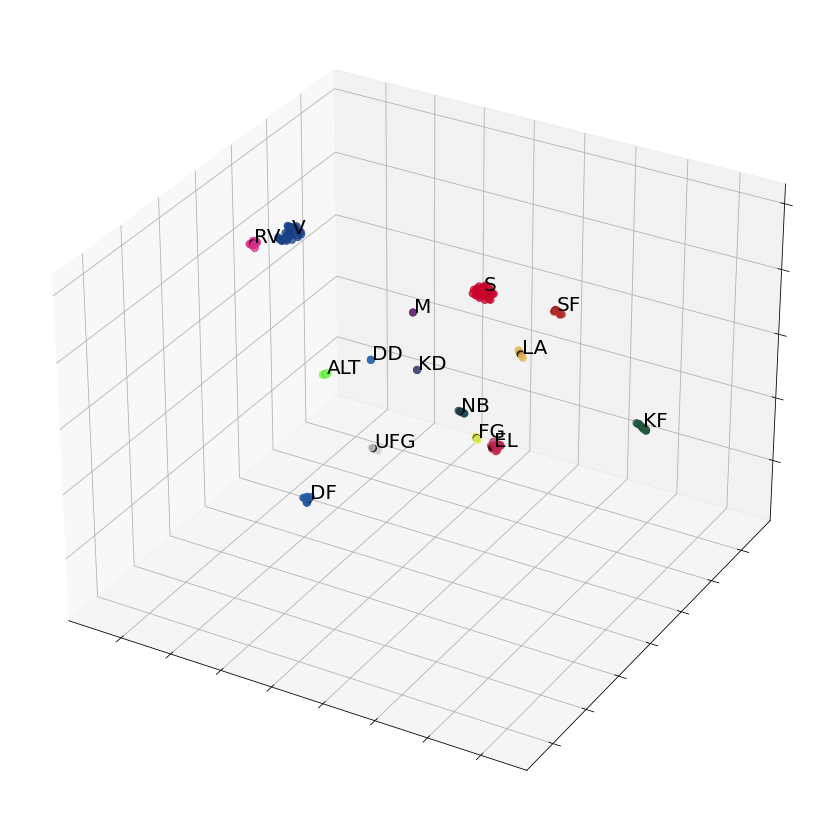

In [51]:
# TWITTER PREPROCCED NAMES
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

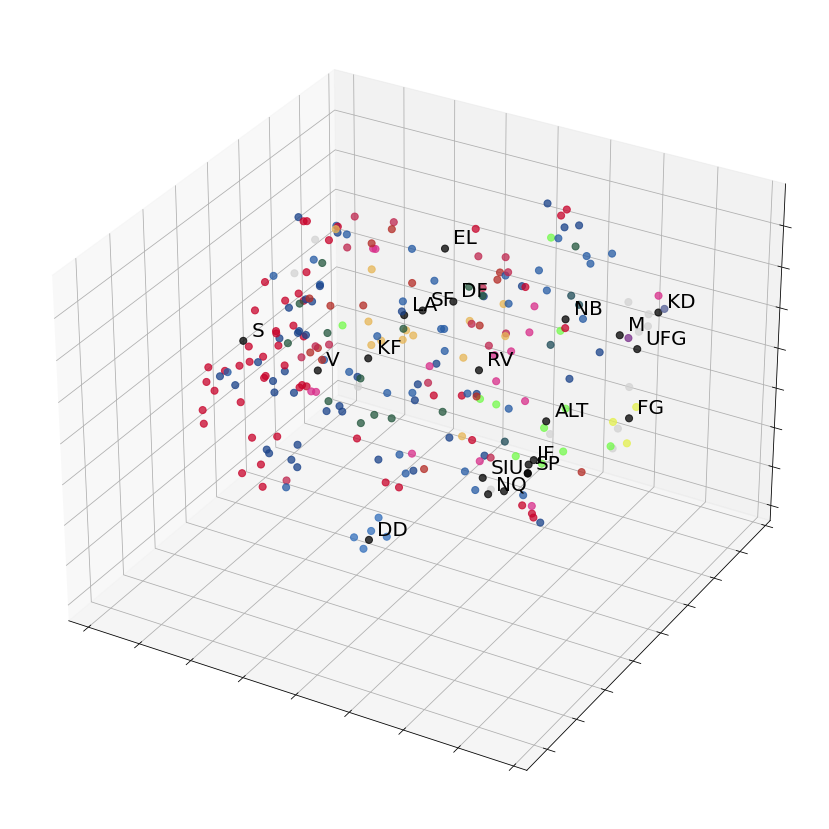

In [261]:
# PARLIAMENT
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(241,260):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

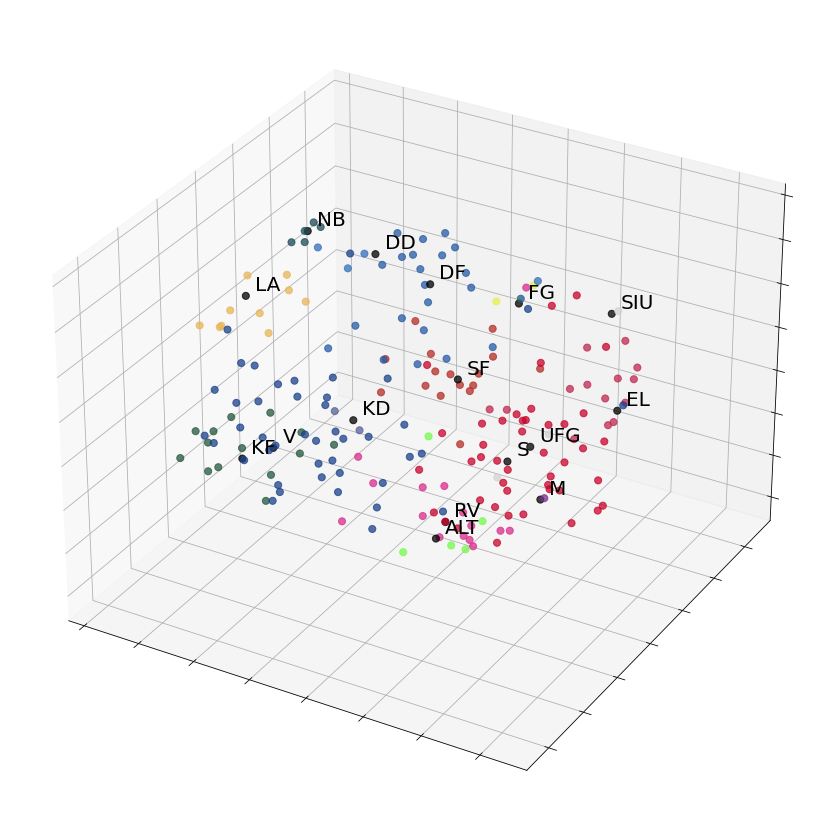

In [182]:
# META
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(201,217):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

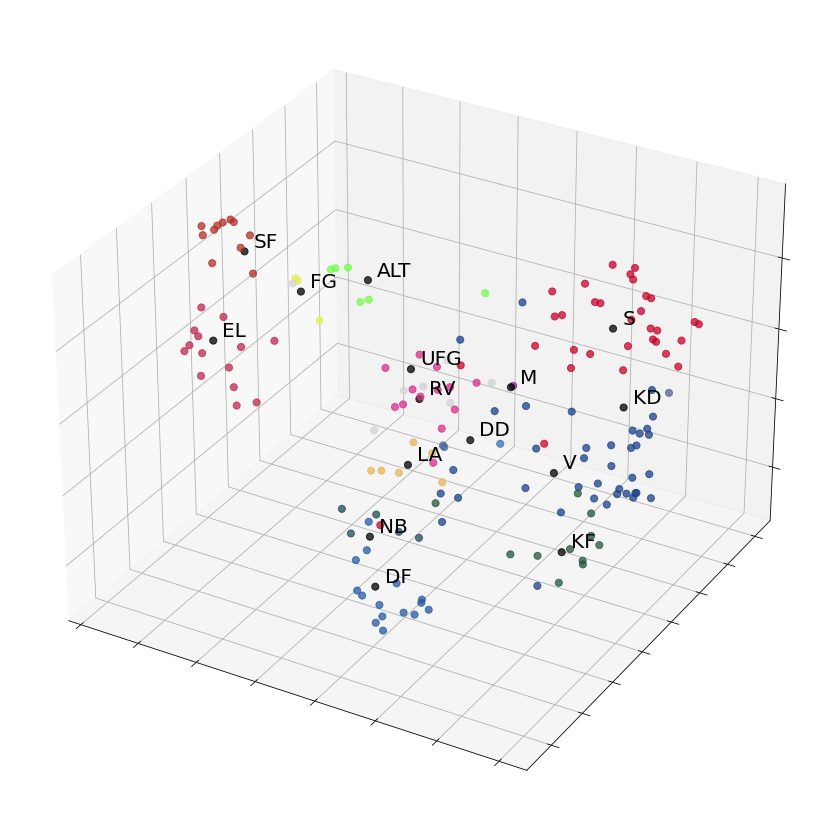

In [523]:
# TWITTER
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

xdata = mapper.embedding_.T[0]
ydata = mapper.embedding_.T[1]
zdata = mapper.embedding_.T[2]

# ax.set_xlim(2.5,6)
# ax.set_ylim(4,7.5)
# ax.set_zlim(4,6.5)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

ax.scatter3D(
    xdata,
    ydata,
    zdata,
    c=combined_hover['color'],
    cmap=combined_hover['color'],
    alpha = 0.75,
    s = 50
    );

for vec_idx in range(166,181):
    x = mapper.embedding_[vec_idx].T[0]
    y = mapper.embedding_[vec_idx].T[1]
    z = mapper.embedding_[vec_idx].T[2]
    ax.text(x+0.05,y+0.05,z+0.05, combined_hover.iloc[vec_idx]['party'], size=20)

____

In [280]:
with open('vocab.txt', 'w') as f:
    f.write('\n'.join(pol2vec_model.vocab))


## TensorBoard exports

In [ ]:
doc2vec2tensor(
    doc2vec_model,
    temp_w2v_path = 'tensorboard_input/temp/doc_tensor_meta.w2v',
    tsv_prefix = 'tensorboard_input/meta',
    output_docvecs = True,
    output_wordvecs = False
)

In [ ]:
metadata2tensor(
    party_df,
    metadata_path = 'tensorboard_input/meta_metadata.tsv',
    label_list = party_labels
)

In [ ]:
# test read of tensor output
with open('tensorboard_input/meta_tensor.tsv','r') as r:
    lines_test = r.readlines()

len(lines_test)

In [ ]:
def partyvecs2tensor(party_vecs, out_path):
    vec_strs = []

    for vec in party_vecs:
        vec_str = ''.join([str(val) +'\t' for val in vec]).rstrip('\t')
        vec_strs.append(vec_str)

    tensor_str = '\n'.join(vec_strs)
    
    with open(out_path, 'w') as f:
        f.write(tensor_str)

In [ ]:
def concat_tensors(tensor_files, out_path):
    tensor_strs = []
    
    for file in tensor_files:
        tensor_str = pd.read_csv(file, sep = '\t', header = None)
        tensor_strs.append(tensor_str)
    
    concat_tensor = pd.concat(tensor_strs)
    
    concat_tensor.to_csv(out_path, sep = '\t', header = False, index = False)

In [ ]:
partyvecs2tensor(
    party_vecs = pol2vec_model.party_vectors,
    out_path = 'tensorboard_input/meta_parties.tsv'
)

In [ ]:
label_df = pd.DataFrame(party_labels, index = ['doc']).T
#label_df['party'] = ''

In [ ]:
label_df.to_csv(
    'tensorboard_input/meta_parties_metadata.tsv',
    sep = '\t',
    header = False,
    index = False
)

In [ ]:
# Combine docvecs and partyvecs
politician_file = 'tensorboard_input/meta_tensor.tsv'
party_file = 'tensorboard_input/meta_parties.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined.tsv')

In [ ]:
# Combine metadata
politician_file = 'tensorboard_input/meta_metadata.tsv'
party_file = 'tensorboard_input/meta_parties_metadata.tsv'

tensor_files = [politician_file, party_file]
concat_tensors(tensor_files, 'tensorboard_input/meta_combined_metadata.tsv')